# The Lempel-Ziv or Ziv-lempel, or, even LZ compression

<!-- PELICAN_BEGIN_SUMMARY -->

Between the years 1976 to 1978, Abraham Lempel and Jacob Ziv created a procedure, and several variants of it, aiming the compression of data. Its latter proposed variants turnout to be a very effective procedure to compress many data types, such as texts and images. The fact that no prior information about the data statistics were required in advance (constrain imposed by statistical compression methods) and the simplistic, but powerfull, algorithm were two facts contributing to the popularity of the LZ compression methods.

Since it's creation, the LZ algorithms have been widely used but in many occasions there's a confusion between which algorithm correspond each variant. Furthermore, the increasing in the amount of data produced have pushed the initial LZ algorithms to be augumented with new data structures in order to become feasible for the analysis of big datasets. Specially for big texts, like human genome that has more than 3 billions ($10^9$) base pairs.

In this post, I plan to cover the whys and whichs of the lempel-ziv algorithms called LZ76, LZ77 and LZ78. 

<!-- PELICAN_END_SUMMARY -->

# LZ78

The lempel-zip compression algorithm proposed in 1978, also called LZ78, processes a text $T[1,n]$ from left to right and cuts it into $z$ substrings, called _phrases_. Navarro, in Compact Data Structures book, defined the algorithm in plain english in a simple way:

> "As the text is parsed, each new phrase is extended as much as possible to the right as long as it matches **some previous phrase**, and then next the new character (the mismatched one) is also included."

This whole process is called the parsing of $T$. A trie is a data structure that can be used to store the parsing results. Basically, a trie is a tree that holds every suffix of a word/text. To spell the suffix from a trie, we traverse it from the root to a leaf outputting the label in the edges found in the path. A trie is usefull in string matching because when comparing a word of size $m$ with a text of size $n$ in the "brute force" way we must perform $m*n$ comparisons, while with the aid of the trie the number of comparisons is the size of the word to be mathed ($m$). If you want to learn more about tries in the context of string matching watch the excelent lecture from Ben Langmead. In fact, I'll use his code as base to the LZ78 python implementation parser.

Be aware that the trie used in LZ78 implementation will not hold every suffix but every node in it represents a phrase (except the root node). Thus, at the end it has $z$ nodes plus the root and each node has a number corresponding to its phrase. I'll put the python implementation of the LZ78 trie bellow based on Ben Langsmead lecture about suffix trie with minor modifications. (BTW his lectures are excelent and I truly recommend them). Then, after the codes we'll give a step by step example. But first, lets load some ipython magics to draw the tries on the notebook using [dot format](https://pt.wikipedia.org/wiki/DOT).




In [0]:
! wget -q https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py

In [0]:
%load_ext gvmagic

In [0]:
class LZ78Trie(object):
  class Node(object):
    def __init__(self, lab, idx):
      self.lab = lab # label on path leading to this node
      self.out = {}  # outgoing edges; maps characters to nodes
      self.idx = idx
  
  def __init__(self, t):
    t += '$'
    self.root = self.Node(None, 0)
    i = 0
    j = 1
    while i < len(t):
      cur = self.root
      for c in t[i:]:
        if c not in cur.out:
          cur.out[c] = self.Node(c,j)
          i += 1
          j += 1
          break
        cur = cur.out[c]
        i += 1
        

  def followPath(object, s):
    cur = self.root
    for c in s:
      if c not in cur.out:
        return None
      cur = cur.out[c]
    return cur
  
  
  def has_substring(self, s):
    """ Return true if s appears as a substring of t """
    return self.follow_path(s) is not None
  
  def to_dot(self, drawend=True):
      """ Return dot representation of trie to make a picture """
      lines = []
      def _to_dot_helper(node, parid, drawend):
          childid = parid
          for c, child in node.out.items():
#              print(c, child)
              if child.lab != '$' or drawend:
                lines.append('  %d -> %d [ label="%s" ];' % 
                             (parid, childid+1, child.lab))
                if child.idx is not None:
                  lines.append('  {} [label="{}"];'.format(childid+1, child.idx))
              childid = _to_dot_helper(child, childid+1, drawend)
          return childid
      lines.append('digraph "Suffix trie" {')
      lines.append('  node [shape=circle label=""];')
      lines.append('  0 [label="{}"];'.format(self.root.idx))
      _to_dot_helper(self.root, 0, drawend)
      lines.append('}')
      return '\n'.join(lines) + '\n'


We show the LZ78 trie example for the text $T=xabxaxa\$$. The parsing begins scanning $T$ for every position $i$, proceeding as follows:

- for $i=0$, there're no previous found phrase, so this is the first time we see the character $T[0]=x$. We append $(0,x)$ to the codded output $out$. Now $out=(0,x)$ and the trie has been augmented with the phrase $x$ with number 1.

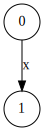

In [4]:
%dotstr LZ78Trie("x").to_dot(False)


- next, for $i=1$, there's no longest prefix of $T[1,7]=abxaxa$ already seen. Therefore, $T[1]=a$ yields a new phrase numbered 2 and $out=(0,x)(0,a)$.




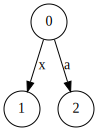

In [5]:
%dotstr LZ78Trie("xa").to_dot(False)

- next, for $i=2$, we have the same situation before but the new phrase is $b$ with number 3.

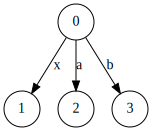

In [6]:
%dotstr LZ78Trie("xab").to_dot(False)

- next, for $i=3$, we have $T=𝑥𝑎𝑥𝑎\$$ and if we walk from root to node number 1 we can see the already phrase $x$. Then, we can encode the prefix $xa$ as $(1,a)$ with the number corresponding to the previous phrase and the next character in the text. We create the node numbered 4 in trie to store the new phrase $xa$.

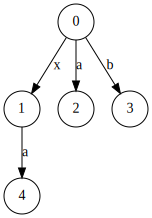

In [7]:
%dotstr LZ78Trie("xabxa").to_dot(False)

- next, we have $i=5$, because we skip 2 positions due the previous phrase $xa$. And, for $i=5$, we notice that $T[5,7]=xa\$$ meaning that the substring $xa$ was already seen in the set of phrases. Therefore, we encode it has $(4,\$)$ and the algorithm ends.

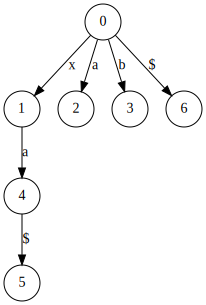

In [8]:
%dotstr LZ78Trie("xabxaxa$").to_dot(True)

The encoded string is $out=(0,x)(0,a)(0,b)(1,a)(4,\$)$ which is bigger than the initial text $T$. But this behaviour is the oposite when the length of the text gets bigger and bigger. Note from our example that the LZ78 algorithm is not suitable to pinpoint repetions. Despite the substring $T[3,5]=xa$ have been seen in $T[0,2]$, the algorithm didn't spot it. The previous variant of lempel-ziv, called LZ76 and almost ever confused with $LZ77$ is best appopriate to this kind of situations, i.e. to compress repetitive texts.

It cannot produce less than $\sqrt{n}$ phrases, even in the text $T=a^n\$$. Why ??

## LZ76

The Lempel-Ziv 1976 compression is similar to LZ78, in which the text is parsed into a sequence of phrases. While in LZ78 the next phrase to be find after parsing $T[1,i]$ must be a previous found phrase plus the symbol following it, in LZ76 the phrase is the longest prefix of $T[i,n]$ that has already appeared in the text plus the symbol following it.

Often LZ76 is mistaken with LZ77, a variant that restricts the length $l$ of the sliding window $T[i-l,i]$ from where the phrases can be detected. This constraint simplifies the finding and enconding the phrases and has the drawback to restrict the search to "nearby" regions in the text.

Let's borrow the mathematical notation used by Gusfield in the classic book _Algorithms on Strings, Trees and Sequences_ to define the output of LZ76 algorithm. According to it, let $Prior_{i}$ be the longest prefix the longest prefix of $T[i,n]$ that also occurs as a substring before the position $i$ in text $T$.

Then, for any position $i$ in $T$, let $l_i$ be length of $Prior_{i}$ and $s_i$ the starting position of the left-most copy of $Prior_{i}$ in $T[0, i-1]$ (using python counting style which is 0-based, i.e. the first character in a string is in 0-th position).

For example, for $T=xabxaxa\$$ the $ Prior_{3} $ is _xa_ leading to $l_{3}=2$ and $s_{3}=0$. The LZ76 algorithm encode it by the pair $(s_i, l_i)$, pointing to the previous ocurrence of a substring.

The LZ76 phrases can be found in linear time with the help of a suffix tree (Rodeh et al, 1981), but this structure requires a lot of extra space, which hampers the parsing of large texts. 

### The suffix tree data structure

The suffix tree (ST) it's nothing more than a compact trie. If we concatenate all the single child nodes into the same node we build a suffix tree from the trie. This is the most naive method to build a suffix tree, requires $O(m^2)$ time and $O(m^2)$ space. A more clever way to build a suffix tree using $O(m)$ space and $O(m^2)$ time was described by Gusfield in ASTS book, section 5.4. There're the Ukkonen's method to build an ST in linear time and space, but it's a detailed algorithm that I'll not cover here. If you wish more infos about Ukkonens method check this excelent [blogpost](https://marknelson.us/posts/1996/08/01/suffix-trees.html).

We list the Naive methods to build a suffix tree:

1. Build the ST from the suffix trie data structure. This method takes $O(m^2)$ time and $O(m^2)$ space.

2. Recursively augment the tree starting from a two-edge tree representing the longest suffix. Then, insert the 2nd longest suffix. Then, the 3rd longest suffix. And so on. It takes $O(m)$ space but still $O(m^2)$ time (Gusfield, section 5.4).

The suffix tree implemented on this post was borrowed from [Ben Langmead teaching materials](http://www.langmead-lab.org/teaching-materials/) and follows the Gusfield algorithm presented in section 5.4. I slightly modified the implementation to accomodate the $m$ suffix numbers in the nodes, where $m$ is the number of suffixes from text $T$. This number will be important in the implementation of the LZ76 parser using suffix trees.


In [0]:
class SuffixTree(object):
  class Node(object):
    def __init__(self, lab, idx):
      self.lab = lab # label on path leading to this node
      self.out = {}  # outgoing edges; maps characters to nodes
      self.idx = idx
      
  def __init__(self, s):
    s += '$'
    self.root = self.Node(None, None)
    self.root.out[s[0]] = self.Node(s, 0) # trie for just longest suffix
    # add the rest of the suffixes, from longest to shortest
    for i in range(1, len(s)):
      # start at root; we'll walking down as far as we can go
      cur = self.root
      j = i
      while j < len(s):
        if s[j] in cur.out:
          child = cur.out[s[j]]
          lab = child.lab
          # walk along edge until we exhaust edge label or until we mismatch
          k = j+1
          while k-j < len(lab) and s[k] == lab[k-j]:
            k += 1
          if k-j == len(lab):
            cur = child # we exhausted the edge
            j = k
          else:
            # we fell off in middle of edge
            cExist, cNew = lab[k-j], s[k]
            # create "mid": new node bisecting edge
            mid = self.Node(lab[:k-j], None)
            mid.out[cNew] = self.Node(s[k:], i)
            # original child becomes mid's child
            mid.out[cExist] = child
            # original child's label is curtailed
            child.lab = lab[k-j:]
            # mid becomes new child of original parent
            cur.out[s[j]] = mid
        else:
          # Fell off tree at a node: make new edge hanging off it
          cur.out[s[j]] = self.Node(s[j:],i)

  def followPath(self, s):
    """ Follow path given by s.  If we fall off tree, return None.  If we
        finish mid-edge, return (node, offset) where 'node' is child and
        'offset' is label offset.  If we finish on a node, return (node,
        None). """
    cur = self.root
    i = 0
    while i < len(s):
        c = s[i]
        if c not in cur.out:
            return (None, None) # fell off at a node
        child = cur.out[s[i]]
        lab = child.lab
        j = i+1
        while j-i < len(lab) and j < len(s) and s[j] == lab[j-i]:
            j += 1
        if j-i == len(lab):
            cur = child # exhausted edge
            i = j
        elif j == len(s):
            return (child, j-i) # exhausted query string in middle of edge
        else:
            return (None, None) # fell off in the middle of the edge
    return (cur, None) # exhausted query string at internal node

  def hasSubstring(self, s):
      """ Return true iff s appears as a substring """
      node, off = self.followPath(s)
      return node is not None

  def hasSuffix(self, s):
      """ Return true iff s is a suffix """
      node, off = self.followPath(s)
      if node is None:
          return False # fell off the tree
      if off is None:
          # finished on top of a node
          return '$' in node.out
      else:
          # finished at offset 'off' within an edge leading to 'node'
          return node.lab[off] == '$'

  def _iterate_over_nodes(self):
    def _to_iter(node):
        for c, child in node.out.items():
          print("Node lab={}, id={}".format(child.lab, child.idx))
          _to_iter(child)
    _to_iter(self.root)
  
  def numerate_internal_nodes(self):
    def preorder_traversal(root):
      yield root
      for c, child in root.out.items():
        yield from preorder_traversal(child)
    return preorder_traversal(self.root)
    
  def to_dot(self):
      """ Return dot representation of trie to make a picture """
      lines = []
      def _to_dot_helper(node, parid):
          childid = parid
          for c, child in node.out.items():
#              print(c, child)
              lines.append('  %d -> %d [ label="%s" ];' % 
                           (parid, childid+1, child.lab))
              if child.idx is not None:
                lines.append('  {} [label="{}"];'.format(childid+1, child.idx))
              childid = _to_dot_helper(child, childid+1)
          return childid
      lines.append('digraph "Suffix trie" {')
      lines.append('  node [shape=circle label=""];')
      _to_dot_helper(self.root, 0)
      lines.append('}')
      return '\n'.join(lines) + '\n'

The example shown by Langsmead in his lecture about suffix trees is reproduced below, i.e. $T=abaaba$. The leaf nodes were labeled with the corresponding suffix number. Internal nodes dont have labels. 

Let`s begin listing all the suffix numbers of $T$ and it's corresponding suffixes.

In [11]:
T = 'xabxaxa'
t = T + '$'
for i in range(len(t)):
  print(i, t[i:])

0 xabxaxa$
1 abxaxa$
2 bxaxa$
3 xaxa$
4 axa$
5 xa$
6 a$
7 $


Then, we build and draw the suffix tree for $T$.

In [0]:
stree = SuffixTree(T)

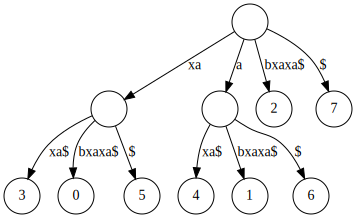

In [13]:
%dotstr stree.to_dot()

Note that every path going from the root to a leaf node produce a suffix of $T$ with the suffix number in the leaf node.

Now that we have a suffix tree implementation we can go back and implement the naive LZ76 parsing algorithm. 

# Naive LZ76 parsing algorithm

The algorithm relies on the suffix tree (ST) for string $T$ to find longest prefix of $T[i,n]$ already seen in $T[1,i-1]$.

1. Build an ST for string $T$;

2. Number each internal node $v$ with $c_v$, the smallest number of all the suffixes in $v$´s subtree; this way, $c_v$ is the left most position in $T$ of any copy of the substring on the path from root to node $v$;

3. To obtain the encoding (position, length), i.e. the pair $(s_{i}, l_{i})$, for the substring $T[i, n]$, whith $0 \leq i \leq n$, do:

  a. Follow the only path from the root that matches the prefix $T[i, n]$ keeping track of all $c_{v}$s found on the path;

  b. The traversal stops at point $p$ which not necessarily is a node, when a character breaks the match;
  
  c. let v be the deepest internal node with the smallest $c_{v}$ found on the path to point $p$ and let depth(v) be the length of the string from the root to v; if we do not cross internal nodes then we output the character $T[i]$; do j <- i + 1. Else, do position $s_{i} = v$ and $l_{i} = depth(v)$;
  
  d. Output encoding $(s_{i}, l_{i})$ and do j <- i + $l_{i}$;
  
  e. Do i <- j + 1; if i = n stop; else goto 3.
  

In [0]:
from collections import defaultdict

class SuffixTreeLZ76(SuffixTree):
      
  def __init__(self, s):
    SuffixTree.__init__(self, s)

  def followPath(self, s):
    """ Follow path given by s.  If we fall off tree, return None.  If we
        finish mid-edge, return (node, offset) where 'node' is child and
        'offset' is label offset.  If we finish on a node, return (node,
        None). """
    cur = self.root
    i = 0
    parent = None # the root not doesnt have parent node
    cvs = []
    path_labs = defaultdict(list)
    while i < len(s):
        c = s[i]
        if c not in cur.out:
            return (None, None) # fell off at a node
        child = cur.out[s[i]]
        lab = child.lab
        idx = child.idx
        cvs.append(idx)
        path_labs[idx].append(lab)
        j = i+1
        while j-i < len(lab) and j < len(s) and s[j] == lab[j-i]:
            j += 1
        if j-i == len(lab):
            parent = cur
            cur = child # exhausted edge
            i = j
        elif j == len(s):
            return (cur, j-i, path_labs) # exhausted query string in middle of edge
        else:
            return (None, None, path_labs) # fell off in the middle of the edge
    return (parent, None, path_labs) # exhausted query string at internal node
  
  def LZ76encoder(self, t):
    """ Perform the LZ76 parsing of T[1,n]. Outputs the phrases ($z$) of the
     LZ76 parsing of T.
    """
    i = 0
    phrases = []
    while i < len(t):
      if i == 0:
        phrases.append(t[0])
        i+=1
      else:  
        right_substring = t[i:2*i]
        node_end, offset, lcvs = self.followPath(right_substring)
        #print("i=",i, right_substring, node_end.idx, lcvs)
        if len(lcvs) == 1 and list(lcvs.keys())[0] == i:
   #       print(t[i])
          phrases.append(t[i])
          i += 1
        else:
          repi = ''.join(lcvs[min(lcvs)])
          li = len(repi)
          if li >= i:
           # print("Here")
           # print("First",i, repi, li)
            offset = (li-i) + 1
            if offset == 1:
              repi = repi[0]
            else:
              repi = repi[:-offset]
            li = len(repi)
           # print("Second",i, repi, li)
          phrases.append((min(lcvs), li))
          i += li
    return phrases
    
  def LZ76decoder(self, phrases):
    """ Decode a LZ78 codded string. Input is a LZ78 codded string. """
    T = ''
    for z in phrases:
      if type(z) == str:
        T += z
      elif type(z) == tuple:
        si, li = z
        T += T[si:si+li]
    return T

  
  def _iterate_over_nodes(self):
    """ Auxiliary function to traverse a tree """
    reverse_dict = {}
    def _to_iter(node, reverse_dict):
        for c, child in node.out.items():
          reverse_dict[child] = node
          print("Node lab={}, id={}".format(child.lab, child.idx))
          _to_iter(child, reverse_dict)
    _to_iter(self.root, reverse_dict)
    return reverse_dict
  
  def do_preorder(self):
    """ Traverse the tree in preorder """
    def preorder_traversal(root):
      yield root
      for c, child in root.out.items():
        yield from preorder_traversal(child)
    return preorder_traversal(self.root)
  
  def do_posorder(self):
    """ Traverse the tree in posorder """
    def posorder_traversal(root):
      for c, child in root.out.items():
        yield from posorder_traversal(child)
      yield root
    return posorder_traversal(self.root)

  
  def rec_dfs(self, root, S=None):
    """ Function to traverse the tree in a depth-first search (DFS) manner """
    if S is None: S = set() # Initialize the history
    S.add(root) # We've visited s
#    print(root.lab, root.idx)
    for c, u in root.out.items(): # Explore neighbors
      if u in S: continue # Already visited: Skip
      self.rec_dfs(u, S) # New: Explore recursively
    return S
    
  def do_rec_dfs(self):
    """ Apply recursive DFS """
    return self.rec_dfs(self.root)
        
  def enumerate_internal_nodes(self):
    """ This function first applies posorder in ST yielding a sorted vector.
    The sorted vector is a set of nodes where the childs come first than
    their parents. For each internal node in sorted vector we perform a DFS with
     the internal node beeing the root yielding the subtree. We get the minimum
     number in the subtree of each internal node as the cv number.
    Enumerate all internal nodes in ST """
    stree_pos = list(self.do_posorder())
    for i in range(len(stree_pos)):
      if stree_pos[i].idx is None:
        stree_pos[i].idx = min([x.idx for x in self.rec_dfs(stree_pos[i]) if x.idx != None])
    
  def to_dot(self):
      """ Return dot representation of trie to make a picture """
      lines = []
      def _to_dot_helper(node, parid):
          childid = parid
          for c, child in node.out.items():
#              print(c, child)
              lines.append('  %d -> %d [ label="%s" ];' % 
                           (parid, childid+1, child.lab))
              if child.idx is not None:
                lines.append('  {} [label="{}"];'.format(childid+1, child.idx))
              childid = _to_dot_helper(child, childid+1)
          return childid
      lines.append('digraph "Suffix trie" {')
      lines.append('  node [shape=circle label=""];')
      lines.append('  0 [label="{}"];'.format(self.root.idx))
      _to_dot_helper(self.root, 0)
      lines.append('}')
      return '\n'.join(lines) + '\n'
    

In [15]:
T

'xabxaxa'

In [0]:
stree = SuffixTreeLZ76(T)

In [0]:
#stree = SuffixTreeLZ76('abbacbba')
#stree = SuffixTreeLZ76('abaaba')
#stree = SuffixTreeLZ76('mississippi')

In [0]:
stree.enumerate_internal_nodes()

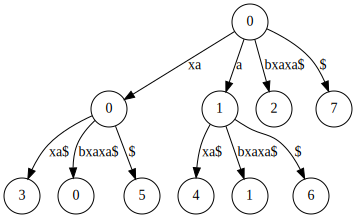

In [19]:
%dotstr stree.to_dot()

The encoded LZ78 for text $T=xabxaxa\$$ is:

In [20]:
zs = stree.LZ76encoder(T+'$'); zs

['x', 'a', 'b', (0, 2), (0, 2), '$']

And using the implementation to decode the parsed string we have.

In [21]:
stree.LZ76decoder(zs)

'xabxaxa$'

**Implementation details and notes**: I dont know if the complexity time is $O(m)$ because my implementation is matching every $T[i..m]$ for all i $\in$ {0..m}. So, maybe it's complexity is growing in order $m^2$ instead of $m$. Certainly the suffix tree construction takes $O(m^{2})$ time. But, when I find a previous match, i.e. a portion of the text that can be compressed, the algorithm jumps the lenght of the compressed part. This may be contributing to lower the running time.

The algorithm perform the enumeration of all internal nodes through the creation of a subtree for each internal node, and them keeps the minimum value found in a leaf belonging to the subtree. Since we have to enumerate the internal nodes from in a bottom-up fashion we first sort the nodes in pos-order. We iterate over the pos-order vector of nodes creating the subtree for each internal node found.

I've used a dictionary to keep track of numbers in the internal nodes encountered and their labels when the algorithm traverses a path from root to $p$. This code is implemented on function `followPath()`. This may be a naive method because we always store a dictionary with all the paths and labels and this can be a burden to very deep suffix trees. Another cavet of the implementation was already mentioned and is related to the fact that every time we traverses all the remaining string. This could be avoided narrowing the traverse path to a number of characters equal to the index i of $T[i..m]$ because we can only have previous substrings of length $i$.

### LZ76 parsing of a genome sequence

Let`s complicate the things in order to test if the LZ76 parsing can handle very long texts. I choose a viral genome, phage lambda, that infects E. coli has our "complicated" example. In fact, this is a very small genome that has only 48.502 base pairs. First we download the genome from NCBI nucleotide collection from this link. But, we'll take another path and download the genome directly from the command line using the python library _ncbi-acc-download_. We do it in the following lines.


In [0]:
! pip install -q ncbi-acc-download

Then, we download the phage lambda genome.

In [0]:
! ncbi-acc-download -m nucleotide -F fasta NC_001416.1

And check if our file is what we`re expecting, i.e. a collection of nucleotides.

In [24]:
! head NC_001416.1.fa

>NC_001416.1 Enterobacteria phage lambda, complete genome
GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCG
TCATAACTTAATGTTTTTATTTAAAATACCCTCTGAAAAGAAAGGAAACGACAGGTGCTGAAAGCGAGGC
TTTTTGGCCTCTGTCGTTTCCTTTCTCTGTTTTTGTCCGTGGAATGAACAATGGAAGTCAACAAAAAGCA
GCTGGCTGACATTTTCGGTGCGAGTATCCGTACCATTCAGAACTGGCAGGAACAGGGAATGCCCGTTCTG
CGAGGCGGTGGCAAGGGTAATGAGGTGCTTTATGACTCTGCCGCCGTCATAAAATGGTATGCCGAAAGGG
ATGCTGAAATTGAGAACGAAAAGCTGCGCCGGGAGGTTGAAGAACTGCGGCAGGCCAGCGAGGCAGATCT
CCAGCCAGGAACTATTGAGTACGAACGCCATCGACTTACGCGTGCGCAGGCCGACGCACAGGAACTGAAG
AATGCCAGAGACTCCGCTGAAGTGGTGGAAACCGCATTCTGTACTTTCGTGCTGTCGCGGATCGCAGGTG
AAATTGCCAGTATTCTCGACGGGCTCCCCCTGTCGGTGCAGCGGCGTTTTCCGGAACTGGAAAACCGACA


Next, we load our genome into a variable to be able to perform some analysis on top of it. The first analysis will be related to the execution time of the implemented algorithm in a range of text lenghts. Be aware that the following codes take some minutes to run !

In [0]:
phage_geno = ''
with open('NC_001416.1.fa', 'r') as phagefa:
  for line in phagefa.readlines():
    if line.startswith('>'):
      continue
    else:
      phage_geno += line.strip('\n')

In [0]:
def do_LZ_parsing(t):
  ST = SuffixTreeLZ76(t)
  ST.enumerate_internal_nodes()
  z = ST.LZ76encoder(t)
  return z

In [0]:
Mrange = 10000

t_LZ76_parsing = []

for M in range(2, Mrange, 500):
  
  t1 = %timeit -n 3 -oq do_LZ_parsing(phage_geno[:M])
  
  t_LZ76_parsing.append(t1.best)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
# use seaborn for nice default plot settings
import seaborn; seaborn.set()


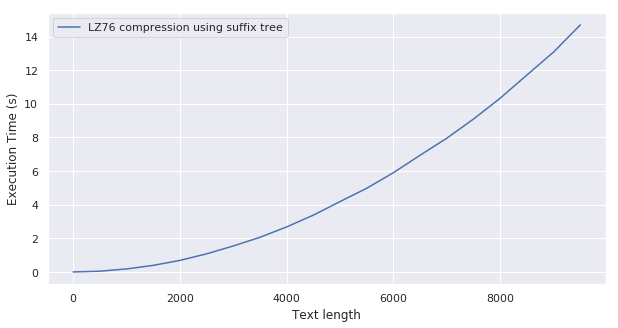

In [45]:
plt.plot(range(2, Mrange, 500), t_LZ76_parsing, label='LZ76 compression using suffix tree')
plt.legend(loc='upper left')
plt.xlabel('Text length')
plt.ylabel('Execution Time (s)');

As we see, the logarithm scales $~O(m^2)$ in the large limit when the text becomes larger and larger. So it is inappropriate for larger genomes. We can also, dig deeper into the code and check which function is taking more time to run using a python utility called `line_profiler`. We can install it through pip, as follows: 


If we consider that every step take $1\ \mu$ second in a computer, and that the algorithm has running time $O(m^2)$ we have the following results.

In [0]:
! pip install -q line_profiler

Once it's installed, we load the extension into the ipython notebook and use the magic function `%lprun` to debug the running time of our functions.

In [0]:
%load_ext line_profiler

In [0]:
def do_LZ_parsing_prof():
  g = phage_geno[:500]
  ST = SuffixTreeLZ76(g)
  ST.enumerate_internal_nodes()
  z = ST.LZ76encoder(g)

In [66]:
%lprun -s -f do_LZ_parsing_prof -T lp_results.txt do_LZ_parsing_prof()
% cat lp_results.txt


*** Profile printout saved to text file 'lp_results.txt'. 
Timer unit: 1e-06 s

Total time: 0.149242 s
File: <ipython-input-64-2529e879245a>
Function: do_LZ_parsing_prof at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def do_LZ_parsing_prof():
     2         1          4.0      4.0      0.0    g = phage_geno[:500]
     3         1      97279.0  97279.0     65.2    ST = SuffixTreeLZ76(g)
     4         1      10262.0  10262.0      6.9    ST.enumerate_internal_nodes()
     5         1      41697.0  41697.0     27.9    z = ST.LZ76encoder(g)

The output shows us that most of the time the parsing spent in building the suffix tree data structure. 



_This post was written entirely in the Jupyter notebook. You can [download](https://github.com/rodtheo/rodtheo.github.io/blob/master/downloads/notebooks/LZ.ipynb) this notebook, or see a static view on [nbviewer](https://nbviewer.jupyter.org/github/rodtheo/rodtheo.github.io/blob/master/downloads/notebooks/LZ.ipynb) or even open it on [google colab](https://colab.research.google.com/drive/1bDi0db3IOw0VO7dpn6wqyKFcQZDdQaT7)._